In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import seaborn as sns
sns.set()
import os
import glob
from tqdm import tqdm
import time
import math

In [2]:
plt.rcParams['figure.figsize'] = [25, 15]

In [3]:
tick_data_path = r'..\data\raw\tick_data'

In [4]:
delivery_info=pd.read_csv('../data/raw/meta_data/delivery_info.csv', index_col=0)
TS_delivery_info = delivery_info[delivery_info.index.str.match('TS')]
TF_delivery_info = delivery_info[delivery_info.index.str.match('TF')]
T_delivery_info = delivery_info[~delivery_info.index.str.match('TS|TF')]

In [5]:
symbol_list = os.listdir(tick_data_path)

# Calculate Trading Frequency

In [6]:
freq = []

for symbol in symbol_list:
    
    contract_list = os.listdir(tick_data_path + '/' + symbol)
    
    for contract in tqdm(contract_list):
        
        df = pd.read_csv(tick_data_path + '/' + symbol + '/' + contract, index_col='trading_date', 
                         parse_dates=True, usecols=['Contract_Code', 'trading_date'])
        
        contract_code = df['Contract_Code'].values[0]
        
        bid_freq = df.groupby('trading_date')['Contract_Code'].count() / 32400
        bid_freq.name = contract_code
        bid_freq.to_csv('../data/interim/bid_freq/' + symbol + '/' + contract_code + '_daily_bid_freq.csv')
        freq.append(bid_freq)

  0%|                                                                                           | 0/19 [00:00<?, ?it/s]D:\anaconda\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  app.launch_new_instance()
100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  6.20it/s]


In [7]:
freq_df = pd.concat(freq, axis=1)

In [8]:
freq_df.columns

Index(['T1509', 'T1512', 'T1603', 'T1606', 'T1609', 'T1612', 'T1703', 'T1706',
       'T1709', 'T1712', 'T1803', 'T1806', 'T1809', 'T1812', 'T1903', 'T1906',
       'T1909', 'T1912', 'T2003', 'TF1312', 'TF1403', 'TF1406', 'TF1409',
       'TF1412', 'TF1503', 'TF1506', 'TF1509', 'TF1512', 'TF1603', 'TF1606',
       'TF1609', 'TF1612', 'TF1703', 'TF1706', 'TF1709', 'TF1712', 'TF1803',
       'TF1806', 'TF1809', 'TF1812', 'TF1903', 'TF1906', 'TF1909', 'TF1912',
       'TF2003', 'TS1812', 'TS1903', 'TS1906', 'TS1909', 'TS1912', 'TS2003'],
      dtype='object')

In [9]:
T_freq_df = freq_df.loc[:, :'T1906'].dropna(how='all')
TF_freq_df = freq_df.loc[:, 'TF1312':'TF1906'].dropna(how='all')

In [16]:
T_freq_df.to_csv('../data/interim/raw_features/T/T_Trading_Frequency.csv')
TF_freq_df.to_csv('../data/interim/raw_features/TF/TF_Trading_Frequency.csv')

## Frequency

In [6]:
T_freq_df = pd.read_csv('../data/interim/raw_features/T/T_Trading_Frequency.csv', index_col=0, parse_dates=True)
TF_freq_df = pd.read_csv('../data/interim/raw_features/TF/TF_Trading_Frequency.csv', index_col=0, parse_dates=True)

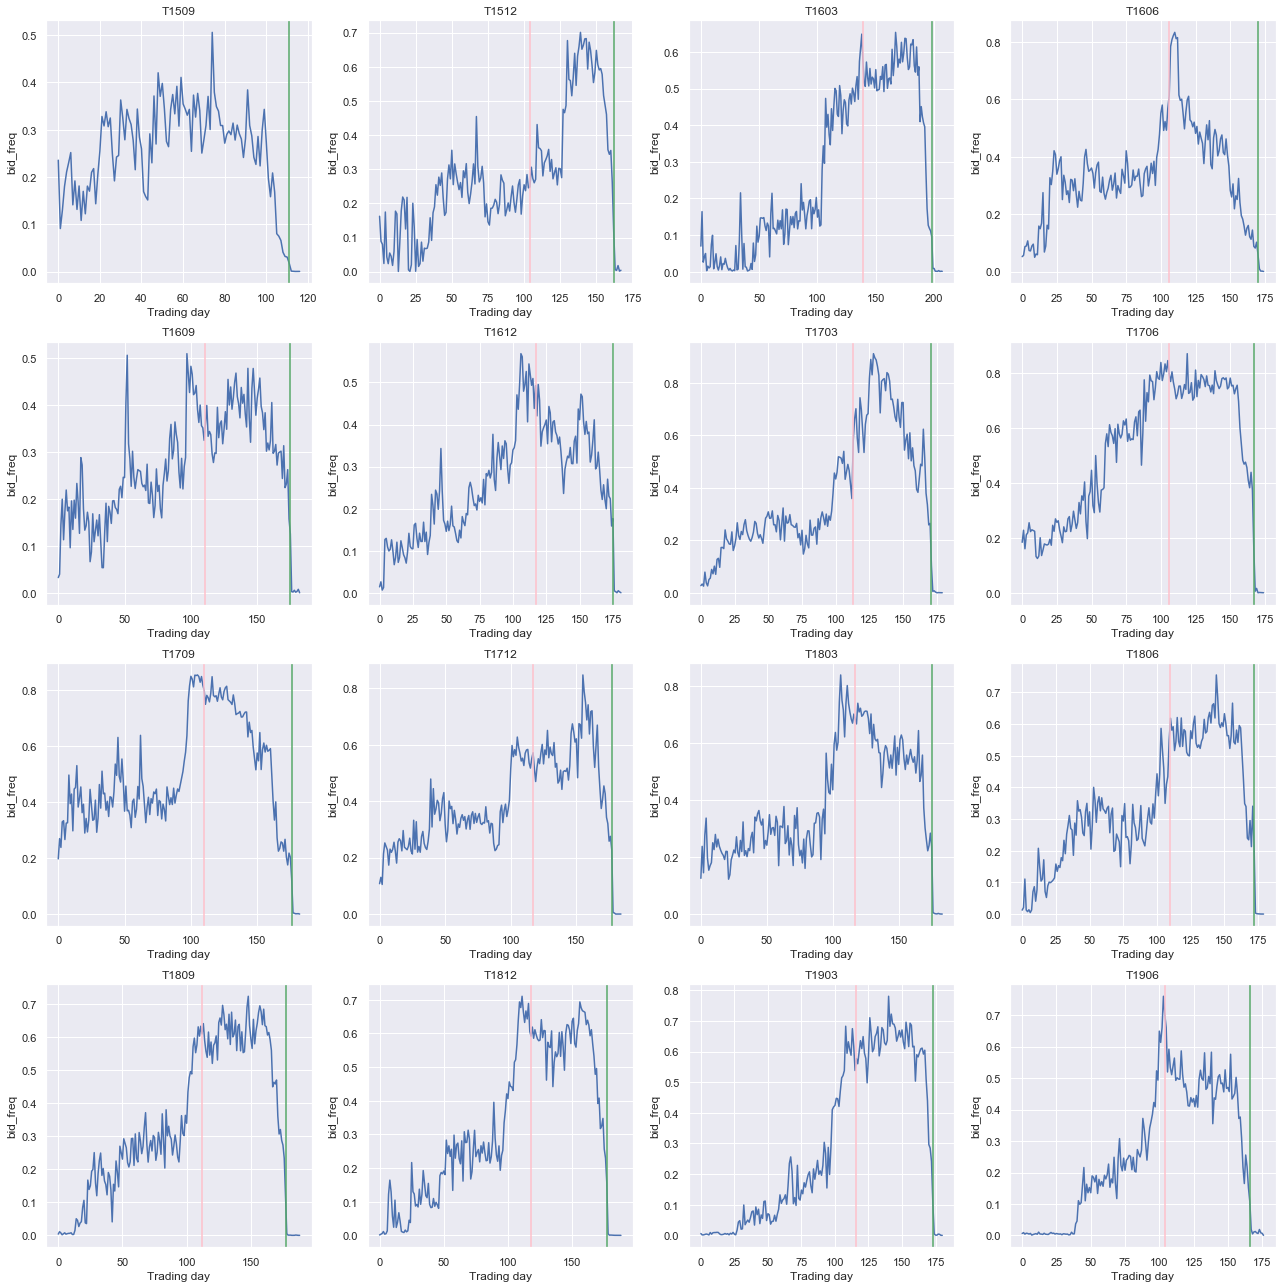

In [7]:
fig, ax = plt.subplots(math.ceil((T_freq_df.shape[1]) / 4), 4, figsize=(18, 18))

for i, contract in enumerate(T_freq_df.columns):
    j = int(i / 4)
    k = i % 4

    ax[j][k].plot(range(len(T_freq_df[contract].dropna())), T_freq_df[contract].dropna())

    intention_day = T_delivery_info['intention_day'][contract]
    intention_idx = (T_freq_df[contract].dropna())[:intention_day].shape[0] - 1
    ax[j][k].axvline(x=intention_idx, c='g')
    
    if contract != T_delivery_info.index[0]:
        last_intention_day = T_delivery_info['intention_day'][:contract][-2]
        last_intention_idx = (T_freq_df[contract].dropna())[:last_intention_day].shape[0] - 1
        ax[j][k].axvline(x=last_intention_idx, c='pink')
    
    ax[j][k].set_xlabel("Trading day")
    ax[j][k].set_ylabel('bid_freq')
    ax[j][k].set_title(contract)

plt.tight_layout()
plt.show()

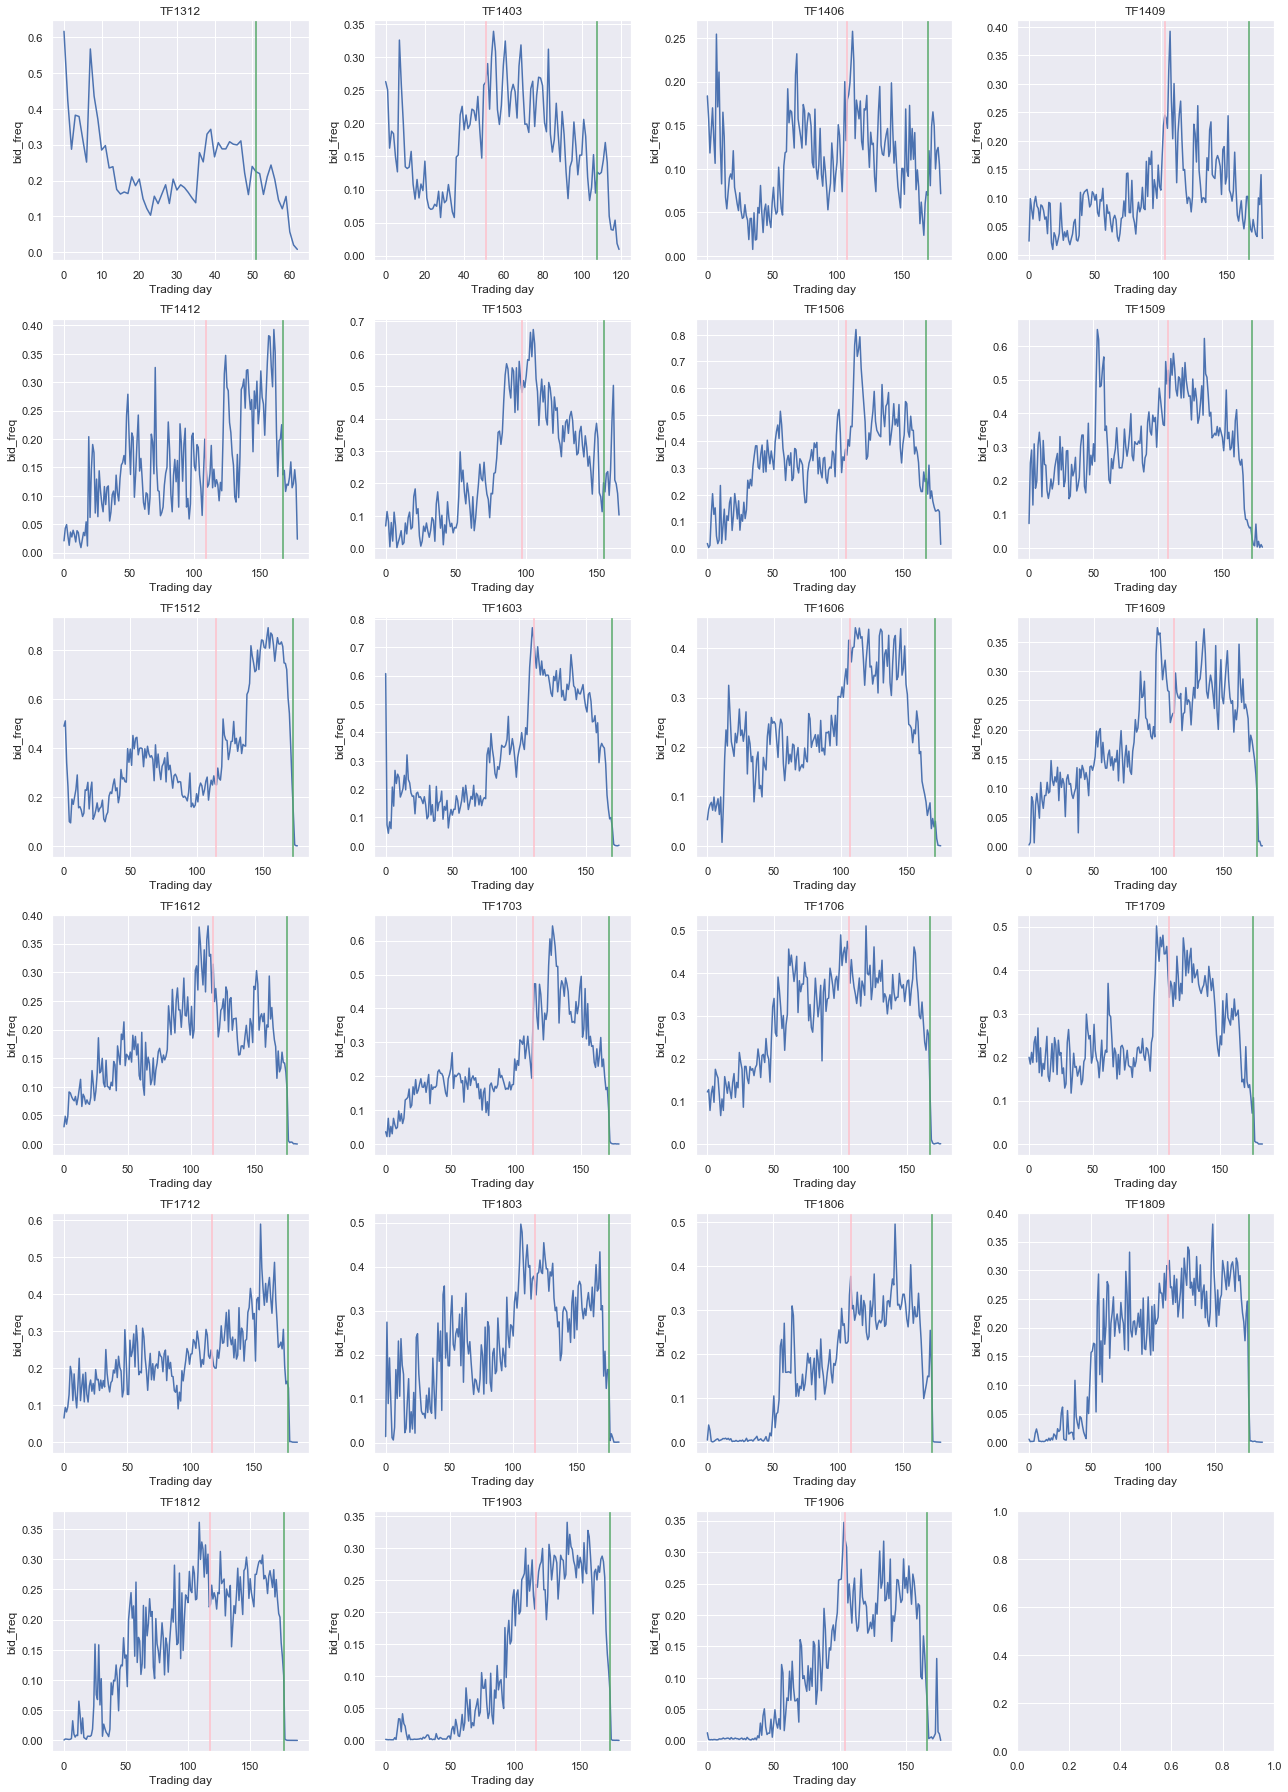

In [8]:
fig, ax = plt.subplots(math.ceil((TF_freq_df.shape[1]) / 4), 4, figsize=(18, 25))

for i, contract in enumerate(TF_freq_df.columns):
    j = int(i / 4)
    k = i % 4

    ax[j][k].plot(range(len(TF_freq_df[contract].dropna())), TF_freq_df[contract].dropna())

    intention_day = TF_delivery_info['intention_day'][contract]
    intention_idx = (TF_freq_df[contract].dropna())[:intention_day].shape[0] - 1
    ax[j][k].axvline(x=intention_idx, c='g')
    
    if contract != TF_delivery_info.index[0]:
        last_intention_day = TF_delivery_info['intention_day'][:contract][-2]
        last_intention_idx = (TF_freq_df[contract].dropna())[:last_intention_day].shape[0] - 1
        ax[j][k].axvline(x=last_intention_idx, c='pink')
        
    ax[j][k].set_xlabel("Trading day")
    ax[j][k].set_ylabel('bid_freq')
    ax[j][k].set_title(contract)

plt.tight_layout()
plt.show()

## Rolling Mean

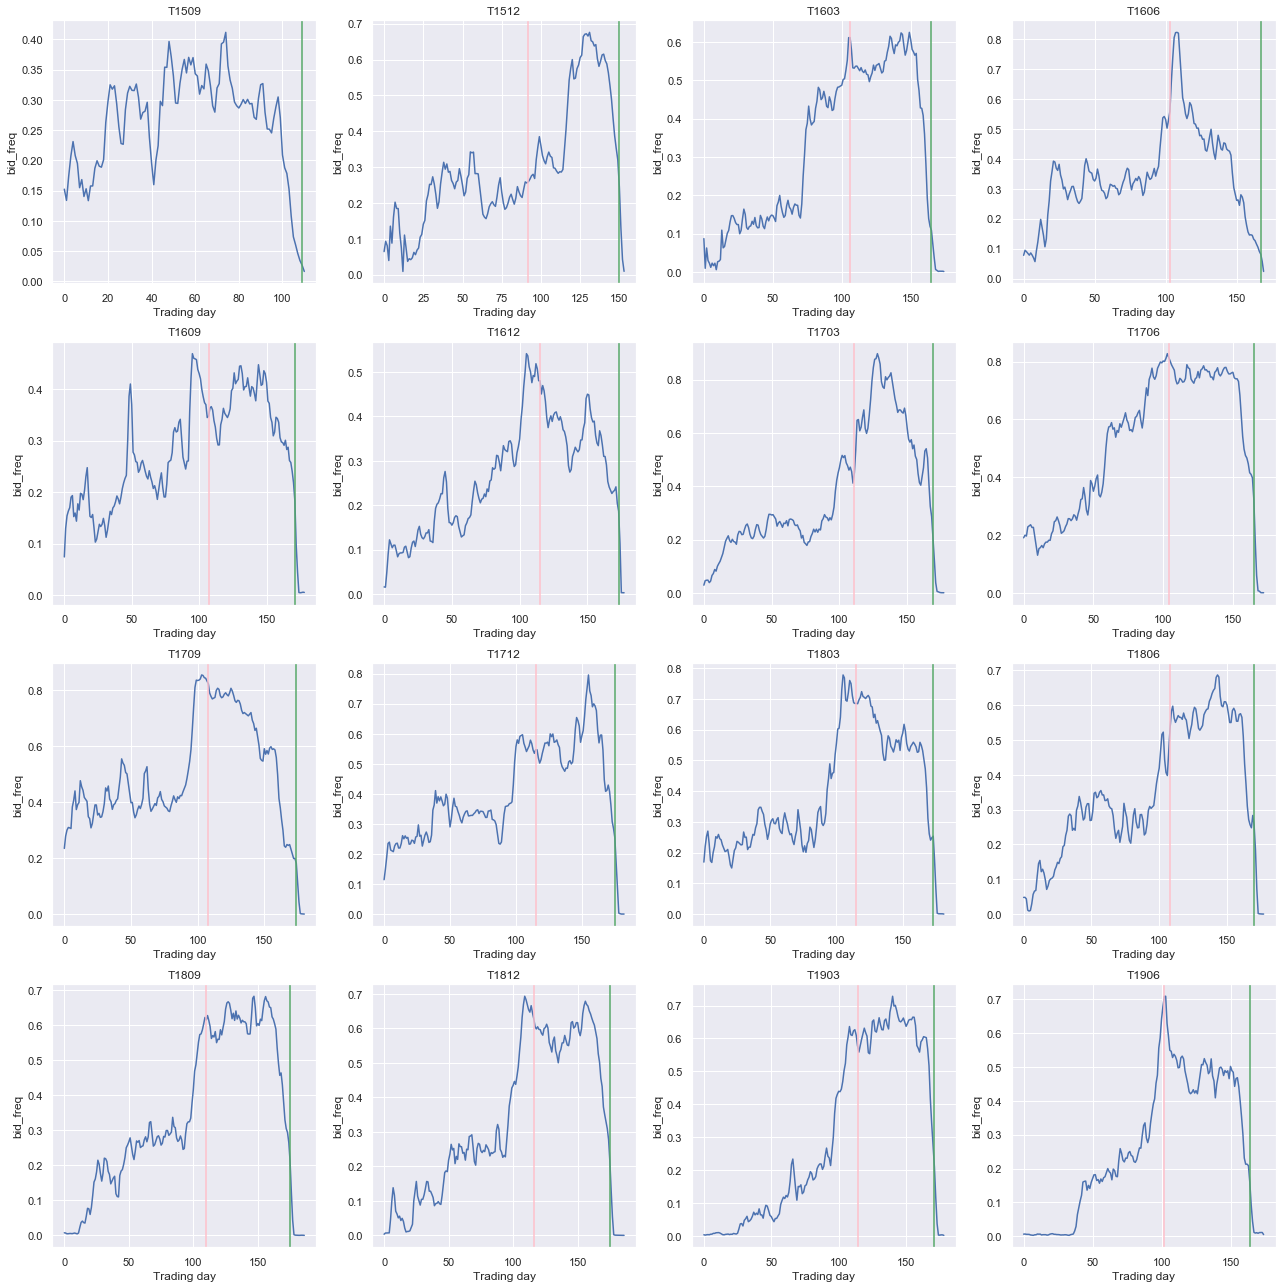

In [9]:
fig, ax = plt.subplots(math.ceil((T_freq_df.shape[1]) / 4), 4, figsize=(18, 18))

for i, contract in enumerate(T_freq_df.columns):
    j = int(i / 4)
    k = i % 4
    
    freq_sample = T_freq_df[contract].rolling(3).mean().dropna()
    ax[j][k].plot(range(len(freq_sample)), freq_sample)

    intention_day = T_delivery_info['intention_day'][contract]
    intention_idx = freq_sample[:intention_day].shape[0] - 1
    ax[j][k].axvline(x=intention_idx, c='g')
    
    if contract != T_delivery_info.index[0]:
        last_intention_day = T_delivery_info['intention_day'][:contract][-2]
        last_intention_idx = freq_sample[:last_intention_day].shape[0] - 1
        ax[j][k].axvline(x=last_intention_idx, c='pink')
        
    ax[j][k].set_xlabel("Trading day")
    ax[j][k].set_ylabel('bid_freq')
    ax[j][k].set_title(contract)

plt.tight_layout()
plt.show()

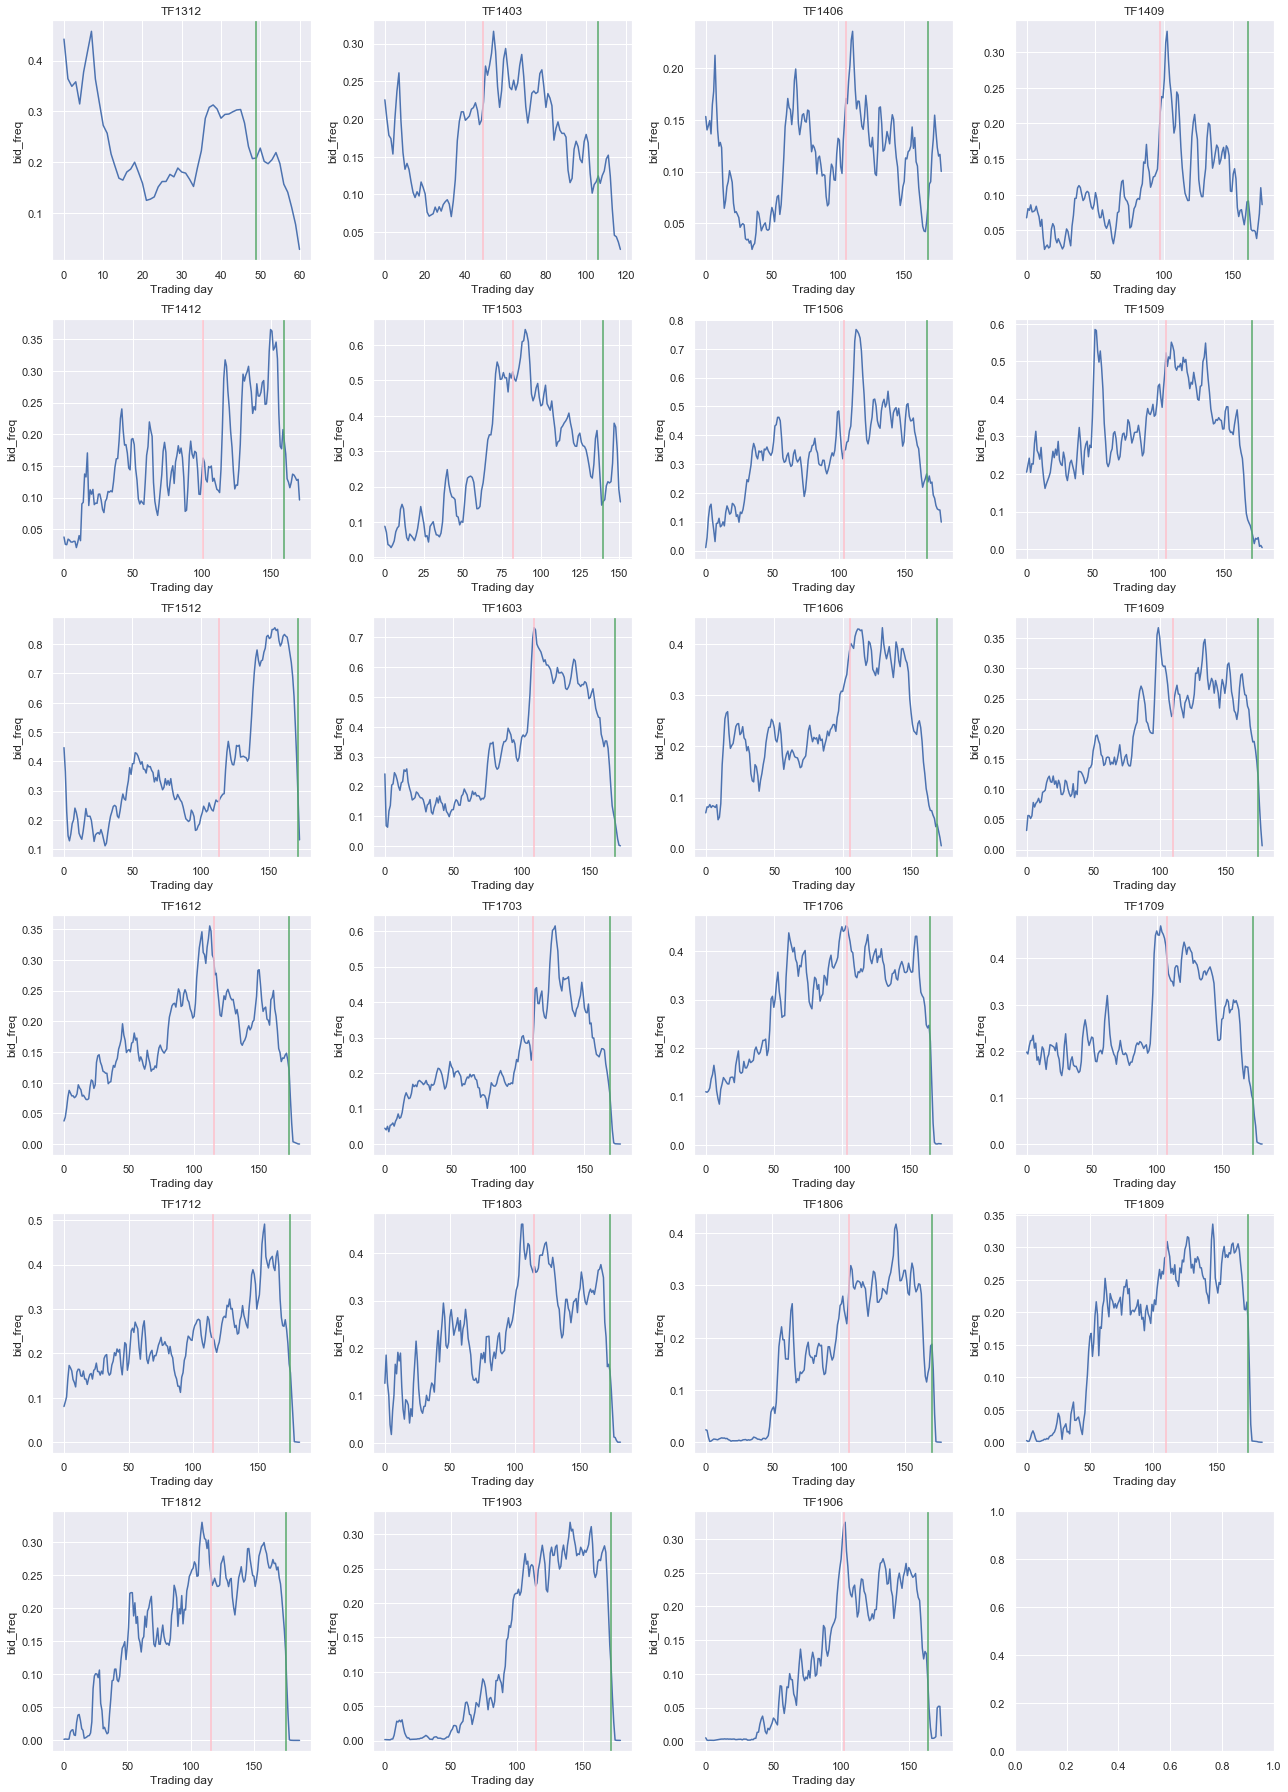

In [10]:
fig, ax = plt.subplots(math.ceil((TF_freq_df.shape[1]) / 4), 4, figsize=(18, 25))

for i, contract in enumerate(TF_freq_df.columns):
    j = int(i / 4)
    k = i % 4
    
    freq_sample = TF_freq_df[contract].rolling(3).mean().dropna()
    ax[j][k].plot(range(len(freq_sample)), freq_sample)

    intention_day = TF_delivery_info['intention_day'][contract]
    intention_idx = freq_sample[:intention_day].shape[0] - 1
    ax[j][k].axvline(x=intention_idx, c='g')
    
    if contract != TF_delivery_info.index[0]:
        last_intention_day = TF_delivery_info['intention_day'][:contract][-2]
        last_intention_idx = freq_sample[:last_intention_day].shape[0] - 1
        ax[j][k].axvline(x=last_intention_idx, c='pink')    
    
    ax[j][k].set_xlabel("Trading day")
    ax[j][k].set_ylabel('bid_freq')
    ax[j][k].set_title(contract)

plt.tight_layout()
plt.show()

## Difference

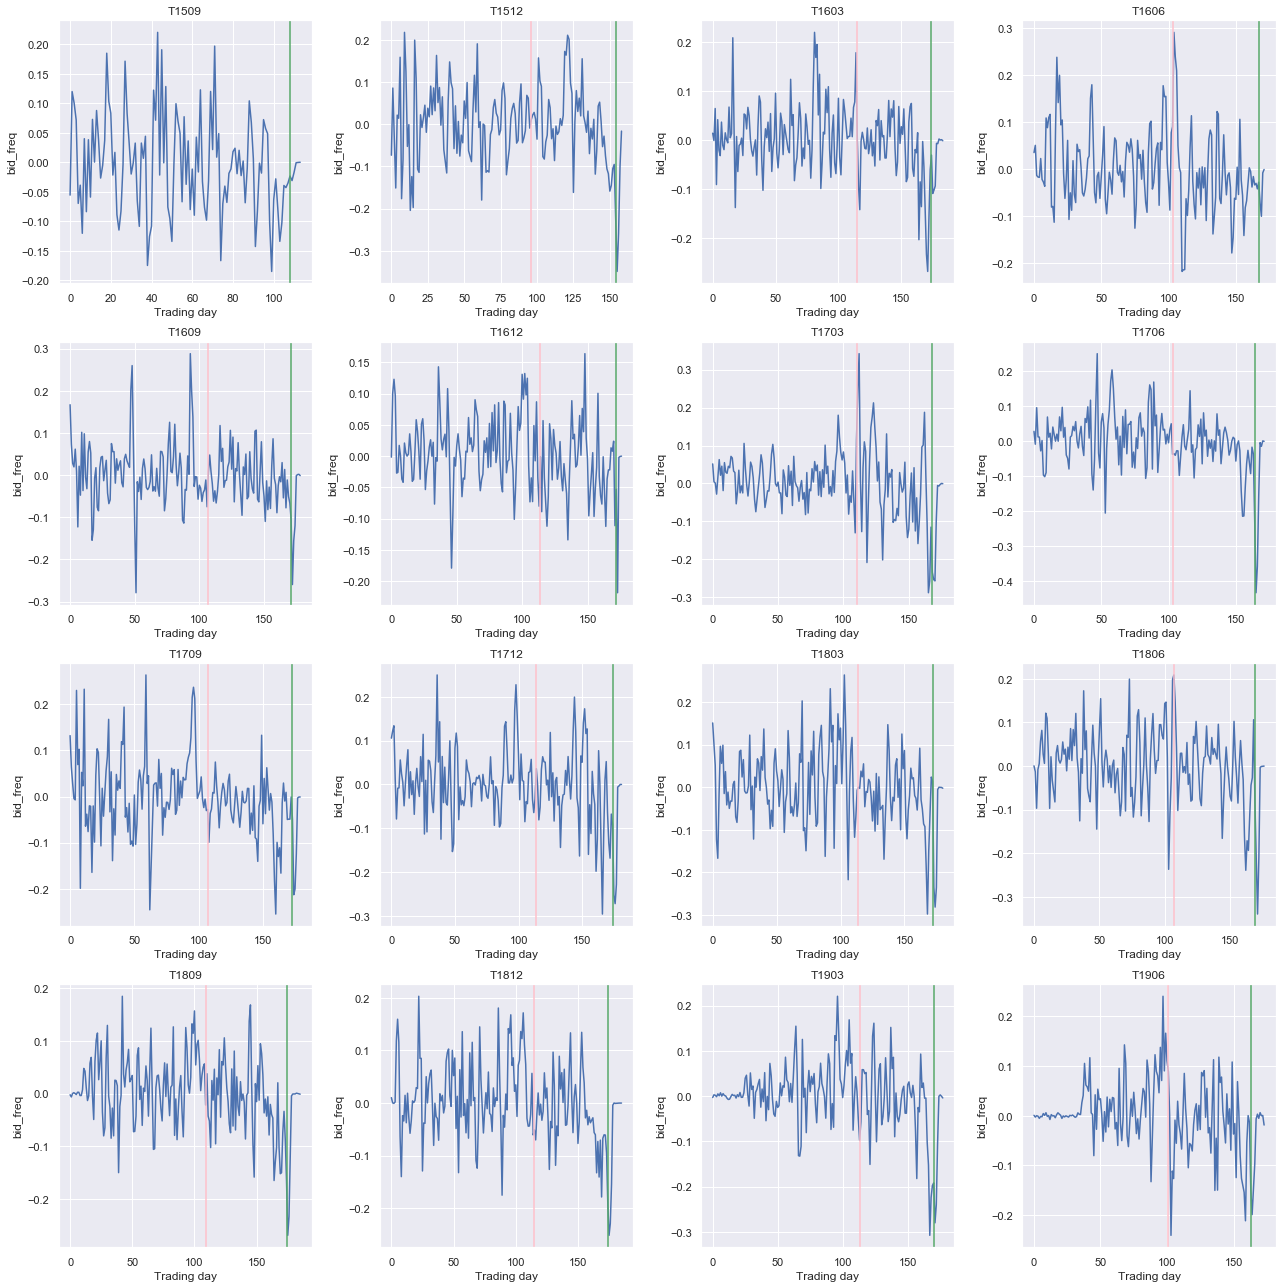

In [11]:
fig, ax = plt.subplots(math.ceil((T_freq_df.shape[1]) / 4), 4, figsize=(18, 18))

for i, contract in enumerate(T_freq_df.columns):
    j = int(i / 4)
    k = i % 4
    
    freq_sample = T_freq_df[contract].diff(3).dropna()
    ax[j][k].plot(range(len(freq_sample)), freq_sample)

    intention_day = T_delivery_info['intention_day'][contract]
    intention_idx = freq_sample[:intention_day].shape[0] - 1
    ax[j][k].axvline(x=intention_idx, c='g')

    if contract != T_delivery_info.index[0]:
        last_intention_day = T_delivery_info['intention_day'][:contract][-2]
        last_intention_idx = freq_sample[:last_intention_day].shape[0] - 1
        ax[j][k].axvline(x=last_intention_idx, c='pink') 
        
    ax[j][k].set_xlabel("Trading day")
    ax[j][k].set_ylabel('bid_freq')
    ax[j][k].set_title(contract)

plt.tight_layout()
plt.show()

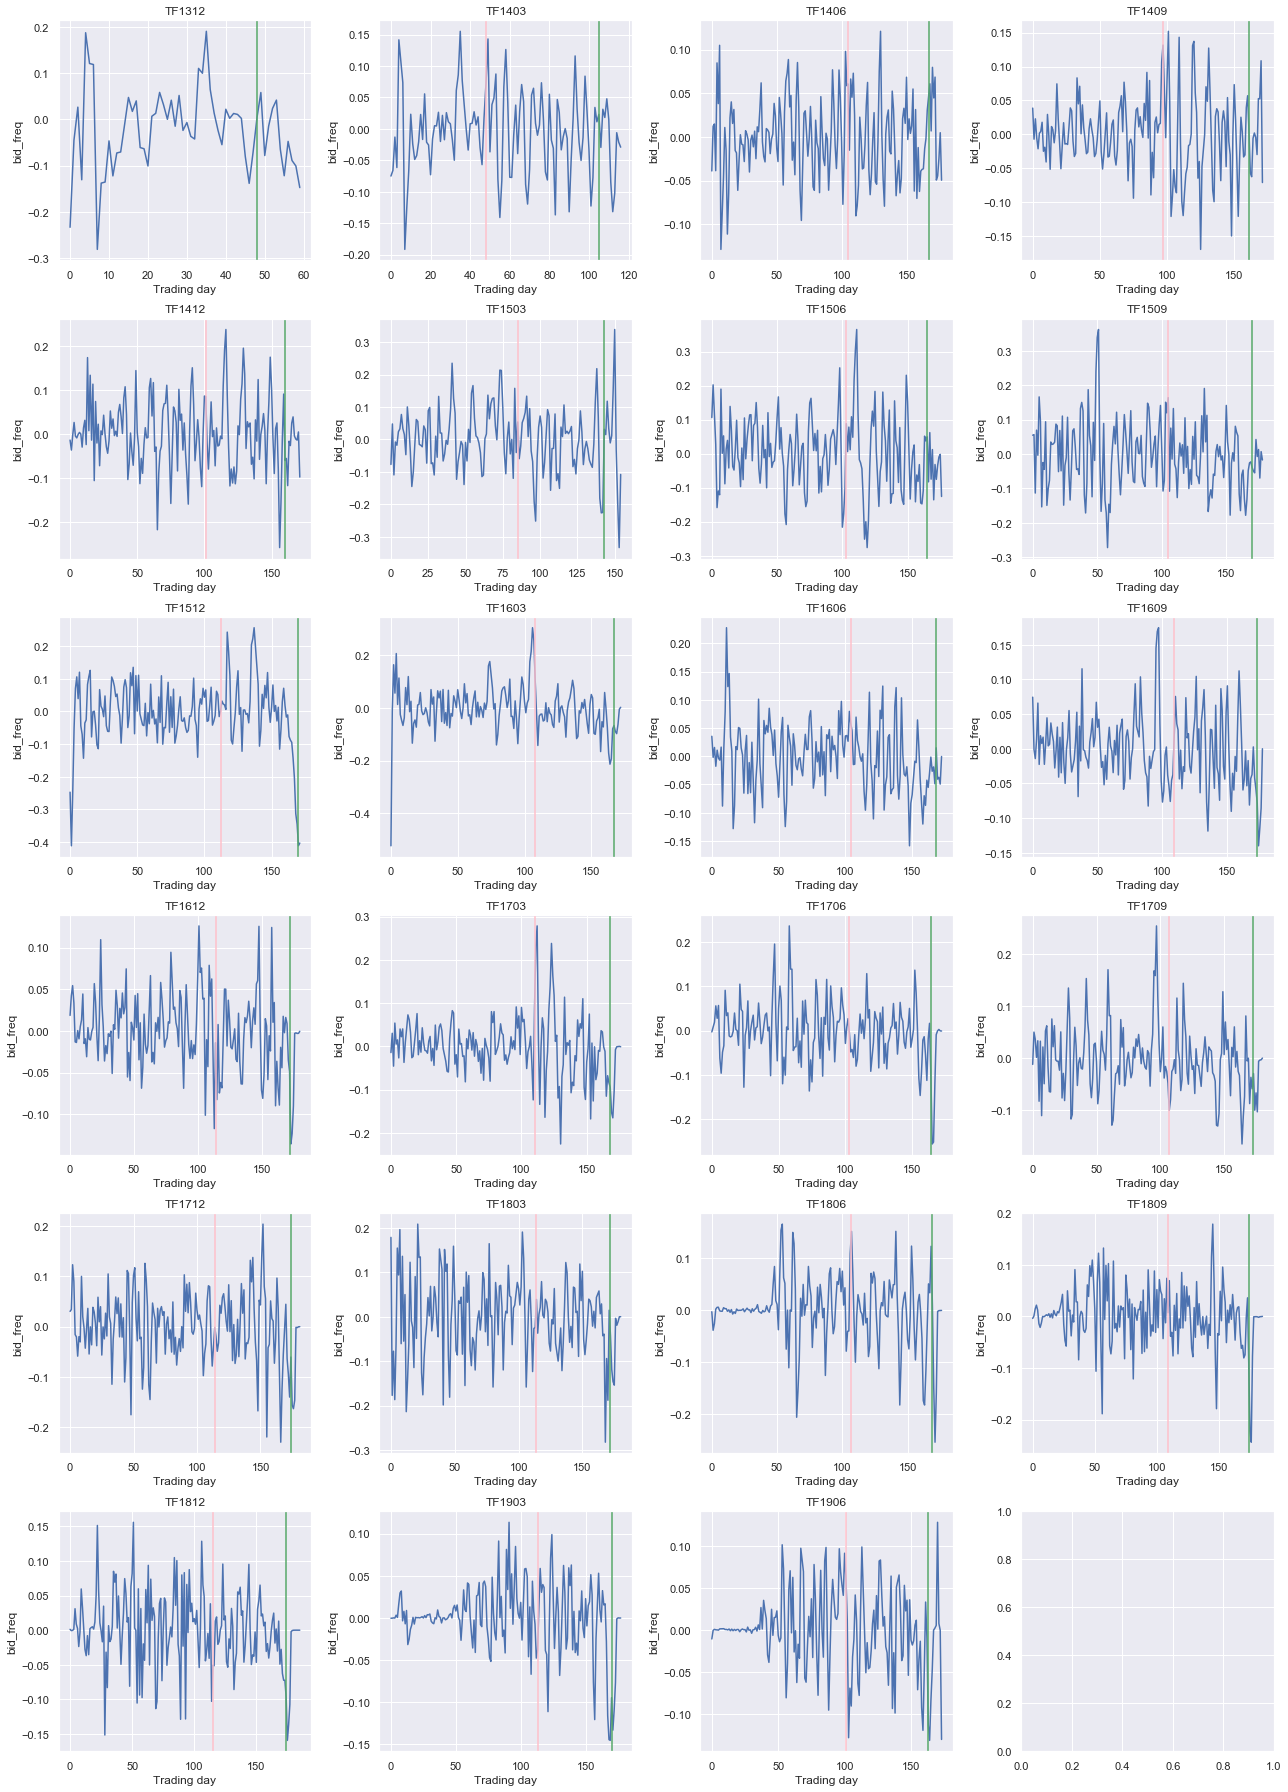

In [13]:
fig, ax = plt.subplots(math.ceil((TF_freq_df.shape[1]) / 4), 4, figsize=(18, 25))

for i, contract in enumerate(TF_freq_df.columns):
    j = int(i / 4)
    k = i % 4
    
    freq_sample = TF_freq_df[contract].diff(3).dropna()
    ax[j][k].plot(range(len(freq_sample)), freq_sample)

    intention_day = TF_delivery_info['intention_day'][contract]
    intention_idx = freq_sample[:intention_day].shape[0] - 1
    ax[j][k].axvline(x=intention_idx, c='g')
    
    if contract != TF_delivery_info.index[0]:
        last_intention_day = TF_delivery_info['intention_day'][:contract][-2]
        last_intention_idx = freq_sample[:last_intention_day].shape[0] - 1
        ax[j][k].axvline(x=last_intention_idx, c='pink') 
        
    ax[j][k].set_xlabel("Trading day")
    ax[j][k].set_ylabel('bid_freq')
    ax[j][k].set_title(contract)

plt.tight_layout()
plt.show()